# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Final

**Harvard University**<br>
**Spring 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Saturday, May 12th, 2018 at 11:59am

**Instructions:**

- Upload your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

# Q1: GLMs with correlation

In Homework 10 you examined the effects of educational attainment and gender on the probability that an indivudal would earn more than $50K per year. However, even the models in the solutions (see Canvas) didn't achieve a perfect fit. Perhaps there was something missing?

## The dataset: A Study of Census Data

In this problem, we are reprising our investigation into the data from the 1994 U.S. Census. The data has been processed so that only a subset of the features are present (for full dataset as well as the description see the UCI Machine Learning Repository).

We'll again want to aggregate the dataset into seven different categories. The categories we wish to consider are:

- 4 year college degree
- Some-college or two year academic college degree
- High school
- Professional, vocational school
- Masters
- Doctorate
- Some or no high school 

Note that we had to combine some of the existing education categories in your dataframe. For each category, we kept track of a count of the number of males and females who make above (and resp. below) $50k

We provide the code below so that all students begin with the same data structure, names, and global parameters.

In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from theano import tensor as tt
from scipy.stats import multinomial
import seaborn as sns
import pandas as pd
import theano as thenr


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\Shaan Desai\Anaconda3\envs\am207\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df = pd.read_csv('census_data.csv')
df.head()

cat_1 = ['11th', '7th-8th', '9th', '5th-6th', '10th', '1st-4th', 'Preschool', '12th']
cat_2 = ['HS-grad']
cat_3 = ['Some-college', 'Assoc-acdm']
cat_4 = ['Assoc-voc', 'Prof-school']
cat_5 = ['Bachelors']
cat_6 = ['Masters']
cat_7 = ['Doctorate']

labels = ["Some HS", "HS Grad", "Some College", "Prof School", "Bachelors", "Masters", "Doctorate"]

categories = [cat_1, cat_2, cat_3, cat_4, cat_5, cat_6, cat_7]
dataset = []
i = 1
for cat in categories:
    filtered = df[df['edu'].isin(cat)]
    dataset.append((i, 0, len(filtered[filtered['sex'] == 'Female']), len(filtered[(filtered['sex'] == 'Female') & (filtered['earning'] == '<=50K')]), len(filtered[(filtered['sex'] == 'Female') & (filtered['earning'] == '>50K')])))
    dataset.append((i, 1, len(filtered[filtered['sex'] == 'Male']), len(filtered[(filtered['sex'] == 'Male') & (filtered['earning'] == '<=50K')]), len(filtered[(filtered['sex'] == 'Male') & (filtered['earning'] == '>50K')])))
    i += 1
dataset = np.array(dataset)
dataset = pd.DataFrame(dataset, columns=['category', 'sex', 'total', '<=50', '>50'])
dataset['category'] = dataset['category']-1 #zero indexing
dataset

,category,sex,total,<=50,>50
0,0,0,1321,1298,23
1,0,1,2932,2711,221
2,1,0,3390,3164,226
3,1,1,7111,5662,1449
4,2,0,3227,2974,253
5,2,1,5131,3732,1399
6,3,0,592,483,109
7,3,1,1366,691,675
8,4,0,1619,1280,339
9,4,1,3736,1854,1882


## Part A: Model 1

In Chapter 13.2 McElreath iterates on his model for the UCB admissions data. (See the attached PDF of that section. We have included pdfs of excerpts from McElreath sections 10.1.3 and 13.2)

**A1**: Implement the upgraded model from section 13.2.1 on the income data. You may refer to Osvaldo Martin's pymc3 implementation of Statistical Rethinking if needed.

In [3]:
Dept_id = dataset['category'].values
Ndept = len(dataset['category'].unique())


In [4]:
#adapted from Osvaldo Martin's implementation
with pm.Model() as var_intercept:
    a = pm.Normal('a', 0, 10)
    bm = pm.Normal('bm', 0, 1)
    sigma_dept = pm.HalfCauchy('sigma_dept', 2)
    a_dept = pm.Normal('a_dept', a, sigma_dept, shape=Ndept)
    p = pm.math.invlogit(a_dept[Dept_id] + bm * dataset['sex'])
    admit = pm.Binomial('admit', p=p, n=dataset['total'], observed=dataset['>50'])
    trace = pm.sample(4500, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Shaan Desai\Anaconda3\envs\am207\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a_dept, sigma_dept_log__, bm, a]


**A2**: You will notice here that the $\alpha$s at different income levels are pooled

1. What criterion do you use to tell if full, partial, or no pooling is appropriate to the given data? 
2. Which type of pooling is implemented here. Why is it most appropriate to our income data?

1 . 
- When we are certain that our data exhibits consistency (e.g. same probability of success - a highly repeatable experiment for example a toin coss) then we are inclined to use full pooling.
- When we are completely uncertain about consistency in our data then we use no pooling, the events are treated as independent and there is no potential link between players, events etc
- When we believe that the data illustrates some general population characteristics (e.g. humans come from the worlds population) then we want to partially pool our information and let the data determine the priors we set on this population.
- Furthermore, we might want to use partial pooling if we realize that no pooling leads to too much variance and over/under estimations and predictions.


2 . 

Here we see partial pooling, it is important to use this here for the last point mentioned in part 1. As stated, we probably overfit the smaller departments (since they had less data) by using no pooling.

**A3**: Sample from the model's posterior and comment on the quality of the samples obtained, examining at least two of the diagnostics discussed in class.

\[Sampling this model took 2 minutes and 30 seconds per chain (~80 it/s) on a VM running on old hardware.\]

In [27]:
pm.summary(trace, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,-1.76,0.60,0.01,-2.62,-0.77,9000.0,1.0
bm,1.37,0.04,0.00,1.32,1.43,3082.0,1.0
a_dept__0,-3.89,0.07,0.00,-4.00,-3.77,6667.0,1.0
a_dept__1,-2.72,0.04,0.00,-2.79,-2.66,4037.0,1.0
a_dept__2,-2.37,0.04,0.00,-2.44,-2.31,4190.0,1.0
a_dept__3,-1.42,0.06,0.00,-1.51,-1.33,6172.0,1.0
a_dept__4,-1.35,0.04,0.00,-1.41,-1.28,4623.0,1.0
a_dept__5,-0.71,0.06,0.00,-0.81,-0.63,6610.0,1.0
a_dept__6,0.02,0.12,0.00,-0.17,0.21,9000.0,1.0
sigma_dept,1.54,0.52,0.01,0.82,2.18,7074.0,1.0


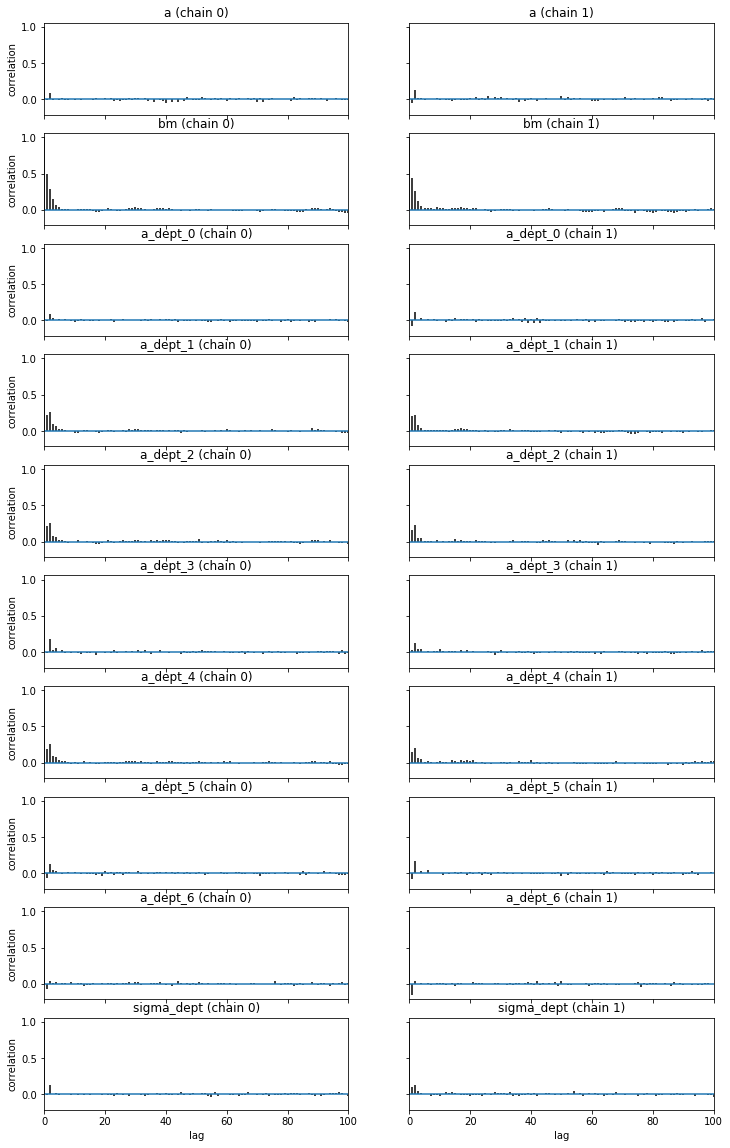

In [19]:
pm.autocorrplot(trace);

We can see that the autocorrelations are dying out quite rapidly

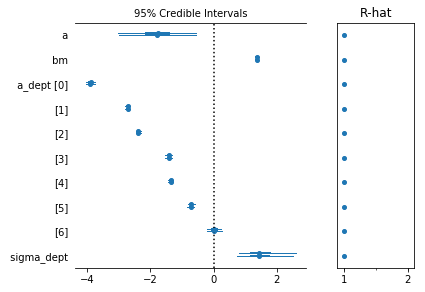

In [23]:
pm.gelman_rubin(trace)
pm.forestplot(trace)

We can see that we achieve stationarity since R hat is 1 for all the parameters.

In [28]:
pm.effective_n(trace)

{'a': 9000.0,
 'a_dept': array([6667., 4037., 4190., 6172., 4623., 6610., 9000.]),
 'bm': 3082.0,
 'sigma_dept': 7074.0}

We can see that the effective number of samples is very high for all parameters which is good

Summary of diagnostics: Low autocorrelation within first few lags, Rhats of 1 for all parameters, and effective sample sizes that are on the order of half or greater than the total number sampled. 

**A4**: Use the code below to plot the amount of shrinkage in our model. Think carefully about what quantity in the dataset and in the posterior you ought to compare. You should see minimal shrinkage in all categories except the last one.

In [6]:
def shrinkage_plot(observed_log_odds, posterior_alpha_means, posterior_alpha_sds):
    """
    observed_log_odds - an entry for each category giving the actual log-odds observed log(P(>50K)/(1-P(>50K)))
    posterior_means - an entry for each category giving the mean of the posterior distribution
    posterior_sds - an entry for each category giving the SD of the posterior distribution
    """
    plt.scatter(range(len(observed_log_odds)),observed_log_odds, label="Observed Log Odds", color='orange')
    plt.errorbar(range(len(posterior_alpha_means)), posterior_alpha_means, yerr = 2*posterior_alpha_sds, fmt='o', label="Posterior for Log Odds\n(mean and 2 SDs)",)
    plt.legend()
    plt.xlabel("Education Category")

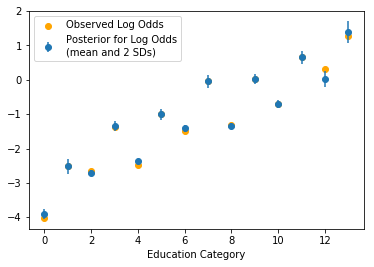

In [10]:
p_50k = dataset['>50']/dataset['total']
log_odds = np.log(p_50k/(1-p_50k))
shrinkage_plot(log_odds,trace['a_dept'].mean(axis=0)[Dept_id]+trace['bm'].mean(axis=0)*dataset['sex'],trace['a_dept'].std(axis=0)[Dept_id]+trace['bm'].std(axis=0)*dataset['sex'])

**A5**: McElreath's new model showed substantial shrinkage within the categories. Why does our model show very minimal shrinkage?. For full credit, include Standard Error in your explanation.

We see minimal shrinkage because for most ouf our education levels the number of samples is quite high meaning we have a good sense for what the posterior should be in the sense that the standard error is small (1/sqrt(n)). However, for the last education category we see that the total column has less data than the other categories which means the standard error is higher which is why we see the most shrinkage in the end.

## Part B: Iterating further

After the pooling model above, McElreath builds a model where the alpha and beta in each unit might be correlated (perhaps the higher the admission rate, the less bias there is towards either gender). 

**B1**: Implement the model in 13.2.2. Feel free to use [code from Osvaldo Martin](https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3/blob/master/Chp_13.ipynb) with attribution and understanding (it contains some sweet pymc3 technical wrangling).

The variable names in this model are unchanged and you may re-name them if you wish.

Note that this model builds the a 7 by 2 matrix with alpha values in the first column and beta values in the second. By assumption, the first column and the second column have correlation structure given by the LKJ prior, but there is no explicit correlation among the rows (aside from all the alphas coming from the same mean). In other words, the correlation matrix is 2x2 (not 14x14) and amongst the income-level-free parts of the intercept and slope.

In [5]:
#adapted from Osvaldo Martins implementation
with pm.Model() as var_slopes:
    a = pm.Normal('a', 0, 10)
    bm = pm.Normal('bm', 0, 1)
    
    sd_dist = pm.HalfCauchy.dist(beta=2)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = tt.dot(chol, chol.T)
    
    # Extract the standard deviations and rho
    sigma_ab = pm.Deterministic('sigma_dept', tt.sqrt(tt.diag(cov)))
    # Compute S = sd*R*sd
    corr = tt.diag(sigma_ab**-1).dot(cov.dot(tt.diag(sigma_ab**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    mu = pm.MvNormal('mvn', mu=tt.stack([a, bm]), chol=chol, shape=(Ndept, 2))
    
    a_dept = pm.Deterministic('a_dept', mu[:, 0])
    a_dept = pm.Deterministic('bm_dept', mu[:, 1])
    
    p = pm.math.invlogit(mu[Dept_id, 0] + mu[Dept_id, 1] * dataset['sex'])
    admit = pm.Binomial('admit', p=p, n=dataset['total'], observed=dataset['>50'])   

**B2**: Sample from the posterior of the model above *with a target acceptance rate of .9 or more*. (Sampling takes 10 minutes per chain on a VM on old hardware and 2 minutes 30 seconds on a recent-gen Mac). Analyze at least two diagnostics and comment on the quality of the samples obtained.

In [6]:
trace_var_slope = pm.sample(5000, tune=1000, model=var_slopes, nuts_kwargs={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Shaan Desai\Anaconda3\envs\am207\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mvn, chol_cov_cholesky_cov_packed__, bm, a]
There were 501 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8443149980859378, but should be close to 0.95. Try to increase the number of tuning steps.
There were 244 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8595715264343722, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller 

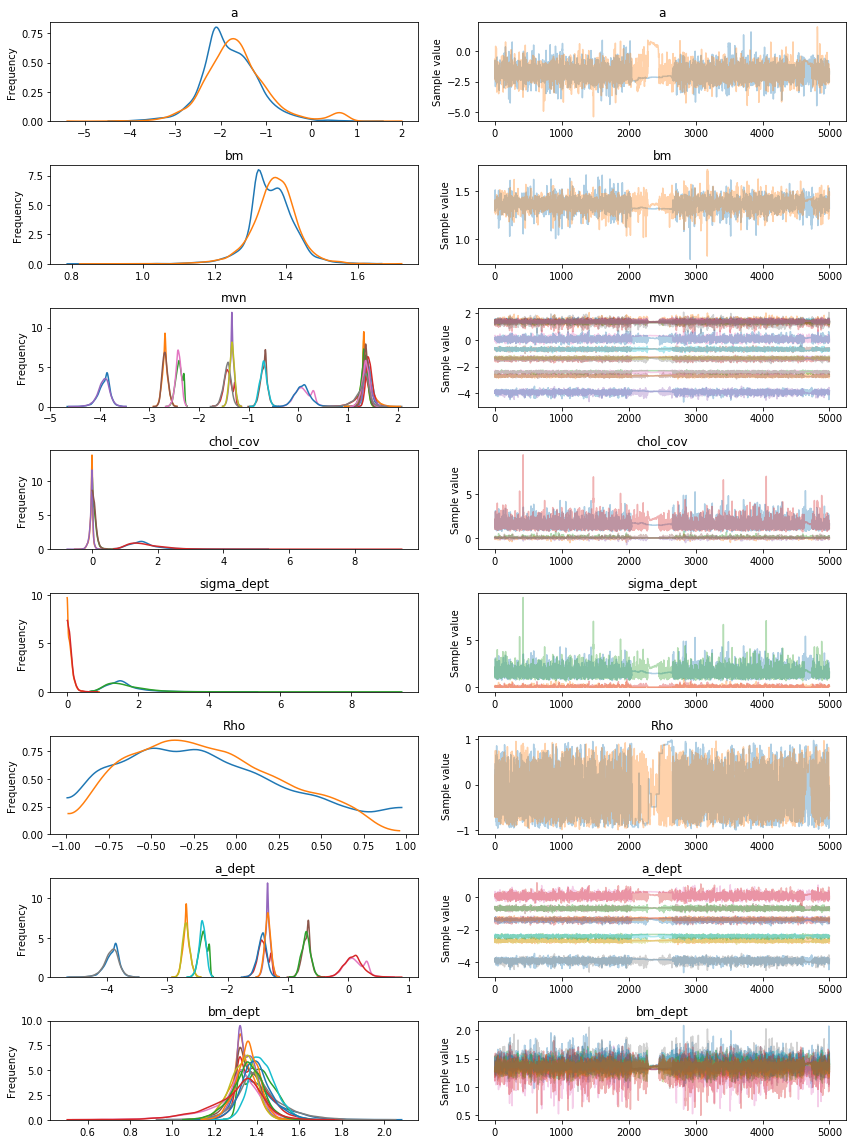

In [7]:
pm.traceplot(trace_var_slope);

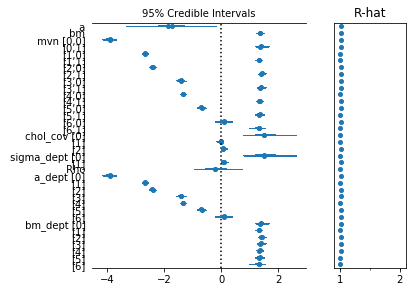

In [8]:
pm.forestplot(trace_var_slope)

In [9]:
pm.effective_n(trace_var_slope)

{'Rho': array([294.]),
 'a': 182.0,
 'a_dept': array([ 550., 2749.,   86.,   83., 5406., 1170.,  140.]),
 'bm': 420.0,
 'bm_dept': array([ 355., 2480.,  103.,  253.,  489., 1585., 1829.]),
 'chol_cov': array([2044., 1861.,  207.]),
 'mvn': array([[ 550.,  355.],
        [2749., 2480.],
        [  86.,  103.],
        [  83.,  253.],
        [5406.,  489.],
        [1170., 1585.],
        [ 140., 1829.]]),
 'sigma_dept': array([2044.,  213.])}

In general the samples appear to be decent because Rhats are close to 1. However, a quick look at effective_n shows us that certain values simply don't have enough samples e.g. sigma_dept. Traces of rho also indicate that there is significant autocorrelation. We also get numerous errors related to divergences indicating our samples aren't great.

**B3**: Propose at least two methods of improving the quality of the samples obtained and explain how/why each method would help. For **some extra credit** implement these. 

Methods:
    
1. Reduce the step size and run the code for longer, this will ensure that we get enough samples in regions where the sampling space is sharp.

2. Use a non centered parametrization. This allows us to fit to a latent variable and then use location scale transforms.

**B4**: Regardless of your answer above, assume the samples are valid and give an analysis of whether the data and models support the hypothesis that males are more advantaged in lower income categories than they are in higher income categories. For full credit, include at least one formal model comparison or probability analysis.

In [10]:
#adapted from Rahuls lecture notes
def make_compare(names, traces, models, ic='WAIC'):
    comparedf=pm.compare(traces,models, method='pseudo-BMA')
    temp=comparedf.sort_index()
    temp['Model']=names
    comparedf = temp.sort_values(ic).set_index('Model')
    return comparedf

In [11]:
names=['var intercept only', 'var intercept + gender slope']
dfc=make_compare(names, [trace,trace_var_slope],[var_intercept,var_slopes])
dfc

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
Model,,,,,,,
var intercept + gender slope,122.74,6.7,0,0.58,4.93,0,1
var intercept only,123.42,6.18,0.68,0.42,5.64,1.38,1


By using the additional gender slope we get a slightly better model than the intercept only. This tells us that by making this a partial pooling case in which we have different gender bias terms for different education levels, we get a better model indicating that males are more advantaged in lower income categories.

**B5**: Regardless of your answer above, assume the samples are valid and give an analysis of: 
1. The posterior probability that males with a Bachelor's degree are more likely to have high incomes than males with a Professional School degree (education categories 3 and 4) \[Specifically, how certain is it that one or the other class has a higher chance of having a high income?\]. 
2. The posterior-predictive on the number of female PhDs earning more than 50K in similarly sized samples

1.

In [12]:
trace_var_slope['a_dept'].shape

(10000, 7)

In [12]:
allps = trace_var_slope['a_dept'].mean(axis=0)[Dept_id]+trace_var_slope['bm_dept'].mean(axis=0)[Dept_id]*dataset['sex']

In [15]:
bachps = trace_var_slope['a_dept'][:,4] + trace_var_slope['bm_dept'][:,4]*dataset['sex'][9]
ed4ps = trace_var_slope['a_dept'][:,3] + trace_var_slope['bm_dept'][:,3]*dataset['sex'][7]
ed3ps = trace_var_slope['a_dept'][:,2] + trace_var_slope['bm_dept'][:,2]*dataset['sex'][5]

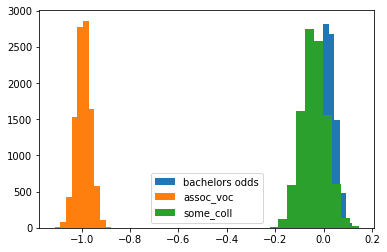

In [25]:
plt.hist(bachps,label='bachelors odds');
plt.hist(ed4ps,label='assoc_voc');
plt.hist(ed3ps,label='some_coll');
plt.legend();

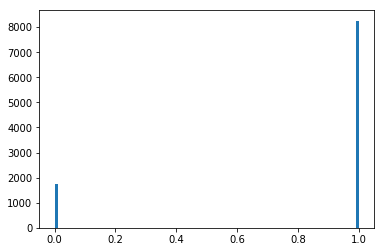

In [30]:
plt.hist(bachps>ed3ps,bins=100);

As we can see, the odds that bachelor's degree holders have a higher than 50K salary is greater than those with Prof-school degres. This makes sense intuitively as well.

2.

In [16]:
ppcs = pm.sample_ppc(trace_var_slope,samples=5000,model=var_slopes)

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3746.10it/s]


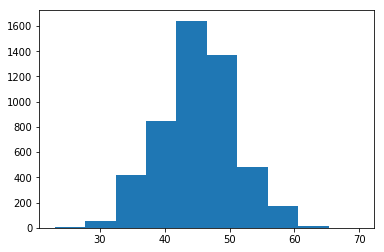

In [17]:
plt.hist(ppcs['admit'][:,12]);

In [18]:
ppcs['admit'][:,12].mean()

45.1154

We can see that the mean posterior predictive of 45 is 5 less than that of the empirical 50. This is due to the partial pooling taking place and the uncertainty we have given only a few PhD's were sampled compared to other groups.

# Q2: Using Mixture of Experts and Mixture Density Networks to Solve Inverse Problems

What if you had to predict a one-to-many function? The data provided below comes from a dataset generated by Chris Bishop (yes that Bishop) to explain the models mentioned in the title above. We have included pdfs from his book which describe these models in some detail.

We read this data in...

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import multinomial
from sklearn.linear_model import LinearRegression
df = pd.read_csv("one-to-many.csv")
df.head()


,target,x
0,0.000000,0.018727
1,0.001001,0.050424
2,0.002002,0.042375
3,0.003003,0.038596
4,0.004004,0.019352


In [3]:
df.shape

(1000, 2)

...and then plot it. Notice both the uneven sampling (more towards the center), and the "more than one y" for a given x.

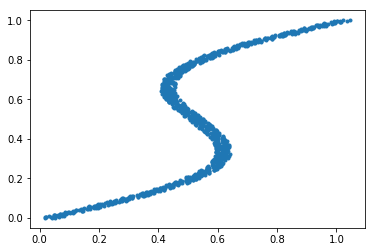

In [4]:
plt.plot(df.x, df.target, '.');

Normal regression approaches to modeling such a function wont work, as they expect the function to be a proper mathematical function, that is, single valued.

These kind of problems are called **inverse problems**, where more than one input state leads to an output state, and we have to try and model these multiple input states.

A mixture of gaussians (or other distributions) might is a sensible way to do this.

You choose one of the gaussians with some probability. The nean of the gaussian is then given by some regression function, say for example a straight line. We could additionally fix the standard deviation or model it as well. 

Thus, for each component Gaussian, we choose a functional form for the mean and standard deviation. So our model looks something like this:

$$f(x)  = \sum_i \lambda_i g_i (x) $$

Say we fit a model with 3 gaussians to this data. Such a model cannot fit the function above. Notice for example that at $x=0.2$ only one of the gaussians will dominate, different from the situation at $x=0.5$. This means that the probabilities of "belonging" to one or the other gaussians is also changing with $x$.

If we allow the mixing probabilities to depend on $x$, we can model this situation.

$$f(x)  = \sum_i \lambda_i (x) g_i (x) $$

Such a model is called a "mixture of experts" model. The idea is that one "expert" gaussian is responsible in one sector of the feature space, while another expert is responsible in another sector.

You can think of this model as implementing a "standard" gaussian mixture at each "point" x, with the added complexity that all of the means, standard deviations, and mixture probabilities change from one x to another.

See https://www.cs.toronto.edu/~hinton/absps/hme.pdf and http://www.ee.hacettepe.edu.tr/~eyuksel/Publications/2012_TwentyYearsofMixtureofExperts.pdf for more details. I found the latter clearer and easier to understand.

For this entire question you might find diagram code from [here](https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb) useful. Take with attribution.

We will assume we have **3 gaussians**.

## PART A: Iterative Linear Regression

The basic idea, illustrated below, is to fit piecewise linear regressions iteratively in a EM style algorithm.

![](images/mixreg0.png)

The algorithm looks like this: initialize the 1000 points in this dataset as randomly belonging to one of 3 "classes" or "clusters" or "experts". This takes a x-data problem and augments it with a fake z data point that tells us whether the point belongs in cluster 0, 1, or 2. (It helps convergence to say that points in the leftmost 0.2 belong to cluster 0 and righmost 0.2 to cluster 2).

Once we have the fake z data we can separate out the 1000 points into 3 sets of points and fit 3 linear regression models. 

We can make predictions for all 1000 points on the data for each of the 3 regression lines. We now assign a data point to the cluster by calculating the squared distances between its actual y value and the 3 cluster predictions and choosing the smallest one.

We then rinse and repeat.

**A1** Implement this algorithm along with a convergence criterion of your choice

**A2** Produce a diagram like the one above which illustrates the straight line fits as well as the cluster belonging. 


In [58]:
z = np.zeros(1000)
#initialize left and right classes
for i in range(200):
    z[i] = 0
    z[-i-1] = 2
#randomly initialize 
z[200:800] = np.where(multinomial.rvs(1,[1./3,1./3, 1./3], size=600)==1)[1]


In [62]:
#newz = np.ones(10)*10**6
zold = np.copy(z)
itern = 0
while itern < 10:
    #linreg for class 0
    ypreds = np.zeros((3,1000))
    for i in range(3):
        x = df.x.values[np.where(z==i)]
        y = df.target.values[np.where(z==i)]
        lr = LinearRegression()
        lr.fit(np.array([x]).T,y)
        ypreds[i,:] = lr.predict(np.array([df.x.values]).T)
    newz = (ypreds-df.target.values)**2
    z = newz.argmin(axis=0)
    itern+=1


In [63]:
df['z'] = z

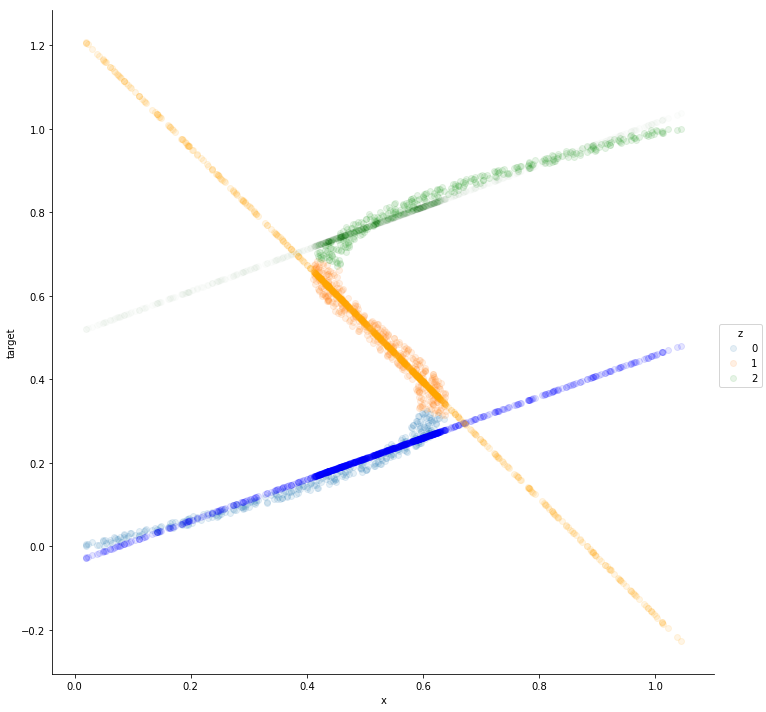

In [65]:
sns.lmplot(x='x',y='target',data=df,fit_reg=False,hue='z',size=10,scatter_kws={'alpha':0.11})
plt.scatter(df.x.values,ypreds[0,:],alpha=0.1,c='b')
plt.scatter(df.x.values,ypreds[1,:],alpha=0.1,c='orange')
plt.scatter(df.x.values,ypreds[2,:],alpha=0.01,c='g')


## Part B: Variational Mixture of Experts

In this part we'll construct a gaussian mixture model of 3 "expert" linear regressions. The idea is to create a fit which looks like this:

![](images/mixreg.png)

Here again the three regression lines work in different regions of $f$. We want a principled way to sample from this model and to be able to produce posterior and posterior-predictive regions.

There are 3 parts to this model. First the means of the gaussians in the mixture are modeled with linear regression as shown in the picture above. We will also model $log(\sigma)$ for each gaussian in the mixture as a linear regression as well ($\sigma$ needs to be positive).

We now need to model the mixture probabilities, i.e., the probabilities required to choose one or the other gaussian. We'll model these probabilities i.e. the $\lambda$s using softmax regression (ie do a linear regression and softmax it to get 3 probabilities).

**B1** Write a pymc3 model for this problem. For all biases and weights in your regressions, assume N(0,5) priors. Add noise 0.01 to each of the three $\sigma$s to make sure you dont have a collapsed 0 width gaussian, ie we want some data in every cluster. (Thus to get the final $\sigma$, you will exponentiate your regression for $log(\sigma)$ and add 0.01.)

**B2** Fit this model variationally for about 50,000 iterations using the adam optimizer. (`obj_optimizer=pm.adam()`) Plot the ELBO to make sure you have converged. Print summaries and traceplots for the means, $\sigma$s and probabilities.

**B3** Plot the mean posteriors with standard deviations against x. Also produce a diagram like the one above to show the means with standard deviations showing their uncertainty overlaid on the data.

**B4** Plot the posterior predictive (mean and variance) as a function of x for this model (using `sample_ppc` for example). Why does the posterior predictive look nothing like the data?

**B5** Make a "correct" posterior predictive diagram by taking into account which "cluster" or "regression line" the data is coming from. To do this you will need to sample using the softmax probabilities. A nice way to do this is "Gumbel softmax sampling". See http://timvieira.github.io/blog/post/2014/07/31/gumbel-max-trick/ for details. Color-code the predictive samples with the gaussian they came from. Superimpose the predictive on the original data. This diagram may look something like this:

![](images/mixpred.png)

#### B1

In [34]:
with pm.Model() as gmm:
    intercept = pm.Normal('Intercept', 0., sd=5.,shape=3)
    m_coeff = pm.Normal('m', 0., sd=5.,shape=3)
    
    mu1 = pm.Deterministic('mu1',var = m_coeff[0]*df.x.values+intercept[0])
    mu2 = pm.Deterministic('mu2',var=m_coeff[1]*df.x.values+intercept[1])
    mu3 = pm.Deterministic('mu3',var=m_coeff[2]*df.x.values+intercept[2])
    
    sig_coeff = pm.Normal('sig_coeff',0.,sd=5.,shape=3)
    intsig = pm.Normal('intsig',0.,5.,shape=3)
    
    logsigma1 = pm.Deterministic('ls1',var = sig_coeff[0]*df.x.values+intsig[0] ) 
    logsigma2 = pm.Deterministic('ls2',var = sig_coeff[1]*df.x.values+intsig[1] ) 
    logsigma3 = pm.Deterministic('ls3',var = sig_coeff[2]*df.x.values+intsig[2] ) 
    
    smint = pm.Normal('smint',0.,sd=5.,shape=3)
    sm_coeff = pm.Normal('sm_coeff',0.,5.,shape=3)
    
    smlr1 = sm_coeff[0]*df.x.values + smint[0]
    smlr2 = sm_coeff[1]*df.x.values + smint[1]
    smlr3 = sm_coeff[2]*df.x.values + smint[2]
    lambdaps = tt.stack([smlr1,smlr2,smlr3],axis=1)
    ps = pm.Deterministic('ps',var=tt.nnet.nnet.softmax(lambdaps))
    
    mu = tt.stack([mu1,mu2,mu3],axis=1)
    sds = tt.stack([tt.exp(logsigma1)+0.01,tt.exp(logsigma2)+0.01,tt.exp(logsigma3)+0.01],axis=1)
    fs = pm.NormalMixture('fs', w=ps, mu=mu, sd=sds, observed=df.target.values)
   # fs = pm.Deterministic('fs',var= ps[:,0]*pm.Normal('g1',mu=mu1,sd=tt.exp(logsigma1)+0.01,observed=df.target.values) + ps[:,1]*pm.Normal('g2',mu=mu2,sd=tt.exp(logsigma2)+0.01,observed=df.target.values) + ps[:,2]*pm.Normal('g3',mu=mu3,sd=tt.exp(logsigma3)+0.01,observed=df.target.values))

#### B2

In [35]:
with gmm:
    inference = pm.ADVI()
    fit = pm.fit(50000,obj_optimizer=pm.adam(),method=inference)

Average Loss = -1,602.8: 100%|██████████████████████████████████████████████████| 50000/50000 [03:24<00:00, 244.72it/s]
Finished [100%]: Average Loss = -1,602.8


Text(0,0.5,'ELBO')

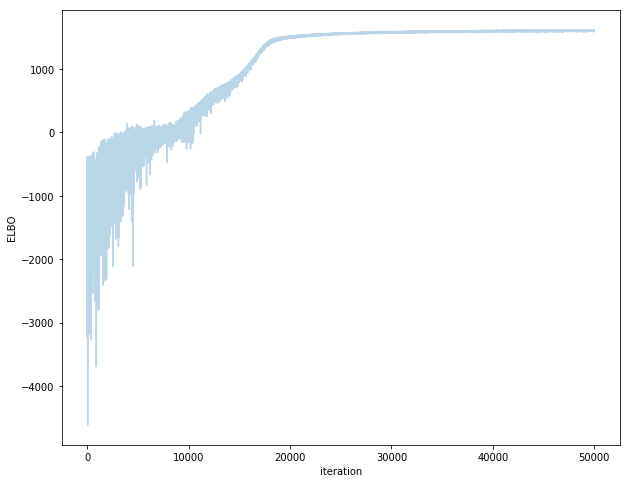

In [36]:
plt.figure(figsize=(10,8))
plt.plot(-inference.hist, label='new ADVI', alpha=.3)
plt.xlabel('iteration')
plt.ylabel('ELBO')

In [37]:
trace = fit.sample(draws=10000)

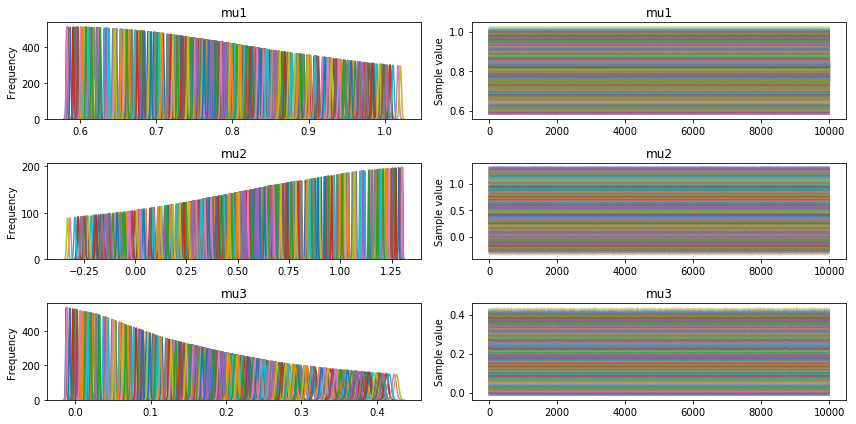

In [41]:
pm.traceplot(trace,varnames=['mu1','mu2','mu3']);

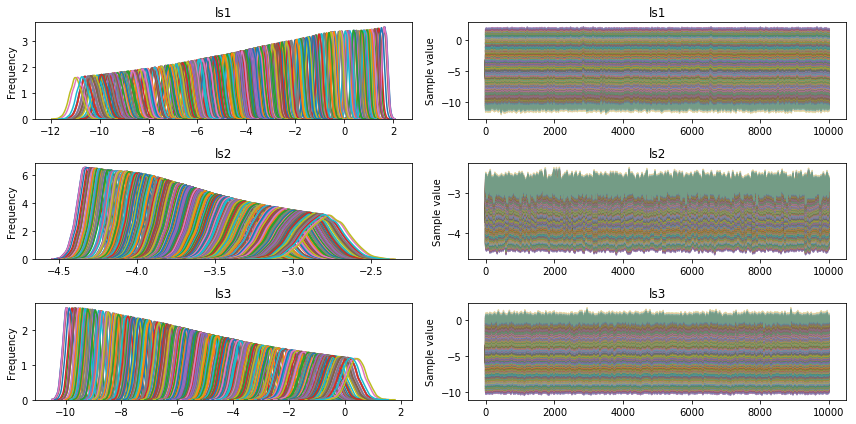

In [43]:
pm.traceplot(trace,varnames=['ls1','ls2','ls3']);

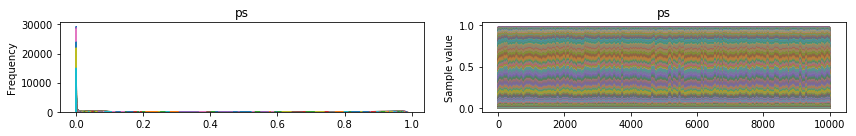

In [44]:
pm.traceplot(trace,varnames=['ps']);

In [47]:
pm.summary(trace,varnames=['mu1','mu2','mu3','ls1','ls2','ls3','ps'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu1__0,0.582786,0.000779,7.544872e-06,0.581316,0.584321
mu1__1,0.596298,0.000780,7.530111e-06,0.594859,0.597873
mu1__2,0.592867,0.000779,7.532338e-06,0.591365,0.594376
mu1__3,0.591256,0.000779,7.533742e-06,0.589809,0.592817
mu1__4,0.583052,0.000779,7.544427e-06,0.581582,0.584587
mu1__5,0.584282,0.000779,7.542448e-06,0.582787,0.585792
mu1__6,0.583426,0.000779,7.543811e-06,0.581956,0.584961
mu1__7,0.601881,0.000781,7.528703e-06,0.600394,0.603409
mu1__8,0.597461,0.000780,7.529591e-06,0.595961,0.598977
mu1__9,0.600971,0.000781,7.528745e-06,0.599483,0.602499


In [48]:
pm.summary(trace,varnames=['Intercept','m','sig_coeff','intsig','smint','sm_coeff'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
Intercept__0,0.574802,0.000779,0.000008,0.573331,0.576335
Intercept__1,1.332853,0.001965,0.000019,1.328995,1.336554
Intercept__2,-0.019837,0.000744,0.000007,-0.021261,-0.018377
m__0,0.426295,0.001003,0.000011,0.424274,0.428229
m__1,-1.591052,0.003810,0.000043,-1.598408,-1.583489
m__2,0.426795,0.002427,0.000026,0.422075,0.431656
sig_coeff__0,-12.334477,0.213874,0.002056,-12.757096,-11.920621
sig_coeff__1,1.513618,0.107355,0.001107,1.302920,1.723648
sig_coeff__2,10.135157,0.276868,0.002909,9.612446,10.699760
intsig__0,1.905474,0.106934,0.001026,1.694765,2.110024


#### B3

Text(0,0.5,'mean of posterior sd')

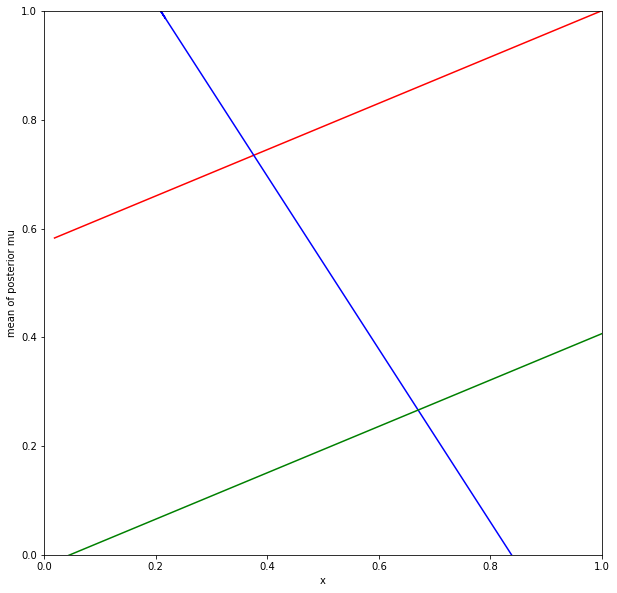

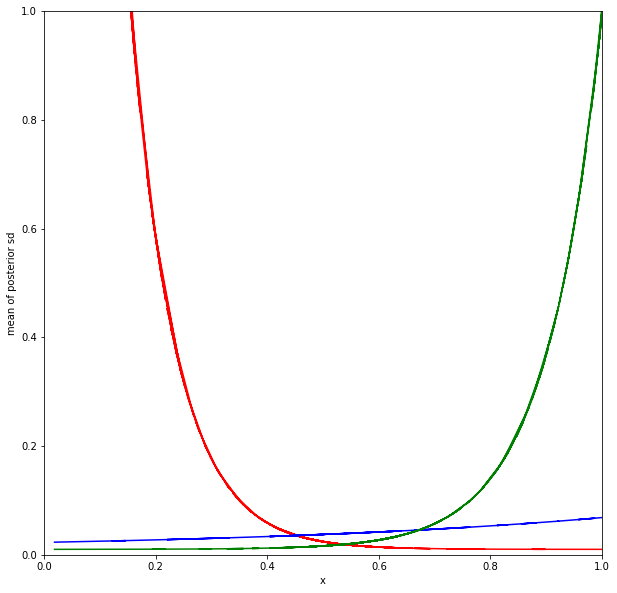

In [71]:
plt.figure(figsize=(10,10))
plt.plot(df.x.values,trace['mu1'].mean(axis=0),c='r')
plt.plot(df.x.values,trace['mu2'].mean(axis=0),c='b')
plt.plot(df.x.values,trace['mu3'].mean(axis=0),c='g')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('x')
plt.ylabel('mean of posterior mu')
plt.figure(figsize=(10,10))
plt.plot(df.x.values,np.exp(trace['ls1'].mean(axis=0))+0.01,c='r')
plt.plot(df.x.values,np.exp(trace['ls2'].mean(axis=0))+0.01,c='b')
plt.plot(df.x.values,np.exp(trace['ls3'].mean(axis=0))+0.01,c='g')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('x')
plt.ylabel('mean of posterior sd')
#plt.fill_between(df.x.values,trace['mu1'].mean(axis=0) -np.exp(trace['ls1'].mean(axis=0))-0.01,trace['mu1'].mean(axis=0)+ np.exp(trace['ls1'].mean(axis=0))+0.01, color='red', alpha=0.1)
#plt.fill_between(df.x.values,trace['mu2'].mean(axis=0) -np.exp(trace['ls2'].mean(axis=0))-0.01,trace['mu2'].mean(axis=0)+ np.exp(trace['ls2'].mean(axis=0))+0.01, color='blue', alpha=0.1)
#plt.fill_between(df.x.values,trace['mu3'].mean(axis=0) -np.exp(trace['ls3'].mean(axis=0))-0.01,trace['mu3'].mean(axis=0)+ np.exp(trace['ls3'].mean(axis=0))+0.01, color='g', alpha=0.1)
# plt.xlim([0,1])
# plt.ylim([0,1])
# plt.xlabel('x')
# plt.ylabel('mean of posterior mu')

Text(0,0.5,'mean of posterior mu')

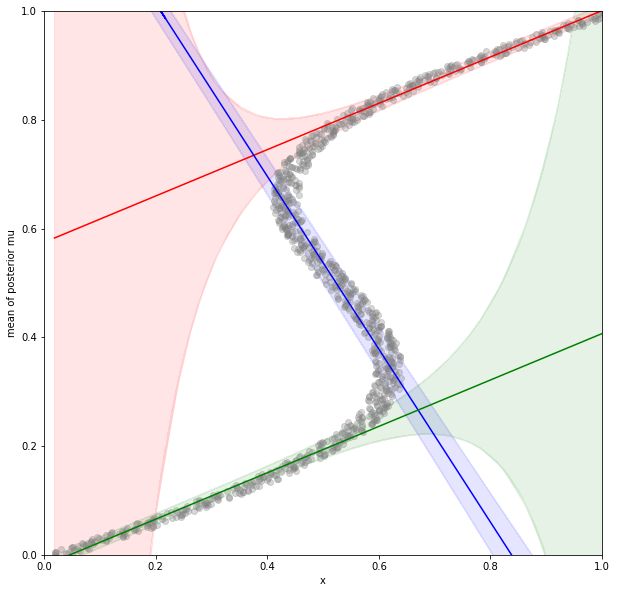

In [68]:
plt.figure(figsize=(10,10))
plt.plot(df.x.values,trace['mu1'].mean(axis=0),c='r')
plt.plot(df.x.values,trace['mu2'].mean(axis=0),c='b')
plt.plot(df.x.values,trace['mu3'].mean(axis=0),c='g')
plt.fill_between(df.x.values,trace['mu1'].mean(axis=0) -np.exp(trace['ls1'].mean(axis=0))-0.01,trace['mu1'].mean(axis=0)+ np.exp(trace['ls1'].mean(axis=0))+0.01, color='red', alpha=0.1)
plt.fill_between(df.x.values,trace['mu2'].mean(axis=0) -np.exp(trace['ls2'].mean(axis=0))-0.01,trace['mu2'].mean(axis=0)+ np.exp(trace['ls2'].mean(axis=0))+0.01, color='blue', alpha=0.1)
plt.fill_between(df.x.values,trace['mu3'].mean(axis=0) -np.exp(trace['ls3'].mean(axis=0))-0.01,trace['mu3'].mean(axis=0)+ np.exp(trace['ls3'].mean(axis=0))+0.01, color='g', alpha=0.1)
plt.scatter(df.x.values,df.target.values,c='grey',alpha=0.3)

plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('x')
plt.ylabel('mean of posterior mu')

#### B4

In [73]:
ppcs = pm.sample_ppc(trace,model=gmm,samples=1000)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:06<00:00, 14.93it/s]


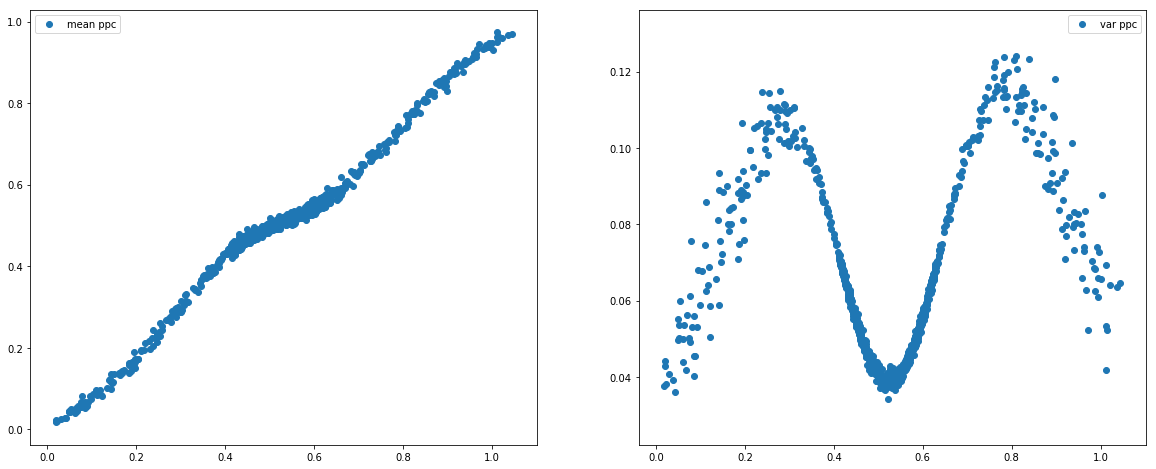

In [78]:
fig,ax = plt.subplots(1,2,figsize=(20,8))
ax[0].scatter(df.x.values,ppcs['fs'].mean(axis=0),label='mean ppc')
ax[0].legend()
ax[1].scatter(df.x.values,ppcs['fs'].var(axis=0),label='var ppc')
ax[1].legend()

The posterior predictive is trying to model a function which cannot be many to 1 so thats why it doesn't look like what we expect. In essence, by taking the mean we are simply taking the squared error (from the decision theoretic perspective) and this doesn't make much sense here because we have three gaussians. We need something like a softmax to help us pick between the three gaussians.

#### B5

In [130]:
mus = np.zeros((1000,3))
mus[:,0] = trace['mu1'].mean(axis=0)
mus[:,1] = trace['mu2'].mean(axis=0)
mus[:,2] = trace['mu3'].mean(axis=0)

stds = np.zeros((1000,3))
stds[:,0] = np.exp(trace['ls1'].mean(axis=0))+0.01
stds[:,1] = np.exp(trace['ls2'].mean(axis=0))+0.01
stds[:,2] = np.exp(trace['ls3'].mean(axis=0))+0.01

def gumbel_max_sample(x):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=1)

In [131]:
#get classes from probabilities to fix issue in B4
classes = gumbel_max_sample(trace['ps'].mean(axis=0))

In [132]:
#compute yhat with the classes 
newvals = []
for i in range(len(classes)):
    newvals.append(np.random.normal(loc=mus[i,classes[i]],scale=stds[i,classes[i]])) 

In [145]:
# add yhat to df for sns plot and create class vector for hue parameter
df['y_ppc'] = newvals
df['classes'] = classes

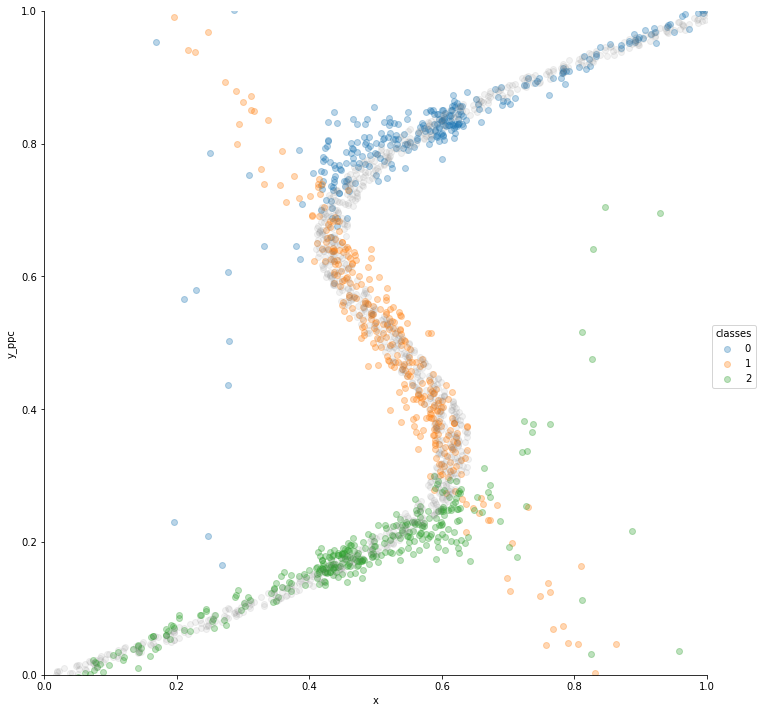

In [146]:
sns.lmplot(x='x',y='y_ppc',data=df,fit_reg=False,hue='classes',size=10,scatter_kws={'alpha':0.311})
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(df.x.values,df.target.values,c='gray',alpha=0.1)

## Part C. Mixture Density Network

A mixture density network (see the enclosed Chapter 5 excerpt from Bishop or https://publications.aston.ac.uk/373/1/NCRG_94_004.pdf) is very closely related to the mixture of experts model. The difference is that we fit the regressions using a neural network where hidden layers are shared amongst the mean, sigma, and mixing probability regressions. (We could have fit 3 separate neural networks in Part A but opted to fit linear regressions for simplicity)

(More explanation [here](https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb). You are welcome to take code from here with attribution.)

You job here is to construct a multi-layer perceptron model with a linear hidden layer with 20 units followed by a `Tanh` activation. After the activation layer, 3 separate linear layers with `n_hidden` inputs and `n_gaussian=3` outputs will complete the network. The probabilities part of the network is then passed through a softmax. The means part is left as is. The sigma part is exponentiated and 0.01 added, as in part A

Thus the structure looks like:

```
input:1 --linear-> n_hidden -> Tanh --linear-->n_gaussians      ...mu
                            --linear-->n_gaussians->softmax     ...lambda
                            --linear-->n_gaussians->exp + 0.01  ...sigma
```

We then need to use a loss function for the last layer of the network. 

Using the mean-squared-error loss is not appropriate as the expected value of samples drawn from the sampling distribution of the network will not reflect the 3-gaussian structure (this is the essence of the difference between B4 and B5 above). Thus we'll use the negative loss likelihood of the gaussian mixture model explicitly.

**C1**: Write the network as a class `MixtureDensityNetwork` which inherits from pytorch `nn.Module`. Implement a constructor which allows at-least the number of hidden layers to be varied. Also implement the `forward` method.

**C2**: Train the network using the Adam or similiar optimizer. Make sure your loss converges and plot this convergence.

**C3**: Plot the MLE parameters against x. Make a plot similar to B3 above where you overlay the "means" of the gaussians against the data.

**C4**: Sample from the sampling distributions to make a plot similar to B5 above

**To think about but not to hand in** What are the differences between a mixture density network and the mixture of experts. How do these differences translate to feature space? What would happen if we took the shared hidden layer nonlinearity (Tanh) out?

I would like to acknowledge my use of the hardmaru code (https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb) in solving this problem.

#### C1

In [33]:
import torch # package for building functions with learnable parameters
import torch.nn as nn # prebuilt functions specific to neural networks
from torch.autograd import Variable # storing data while learning

class MDN(nn.Module):
    def __init__(self, n_hidden, n_gaussians):
        super(MDN, self).__init__()
        self.z_h = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.Tanh()
        )
        self.z_pi = nn.Linear(n_hidden, n_gaussians)
        self.z_sigma = nn.Linear(n_hidden, n_gaussians)
        self.z_mu = nn.Linear(n_hidden, n_gaussians)  

    def forward(self, x):
        z_h = self.z_h(x)
        pi = nn.functional.softmax(self.z_pi(z_h), -1)
        sigma = torch.exp(self.z_sigma(z_h))+0.01
        mu = self.z_mu(z_h)
        return pi, sigma, mu

In [34]:
oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi) # normalization factor for Gaussians
def gaussian_distribution(y, mu, sigma):
    # make |mu|=K copies of y, subtract mu, divide by sigma
    result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)
    result = -0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(sigma)) * oneDivSqrtTwoPI

def mdn_loss_fn(pi, sigma, mu, y):
    result = gaussian_distribution(y, mu, sigma) * pi
    result = torch.sum(result, dim=1)
    result = -torch.log(result)
    return torch.mean(result)

#### C2

In [35]:
network = MDN(n_hidden=20, n_gaussians=3)
optimizer = torch.optim.Adam(network.parameters())
n_samples = len(df.x.values)
n_input = 1
x_tensor = torch.from_numpy(np.float32(df.x.values).reshape(n_samples, n_input))
y_tensor = torch.from_numpy(np.float32(df.target.values).reshape(n_samples, n_input))


mdn_x_data = df.x.values
mdn_y_data = df.target.values

mdn_x_tensor = x_tensor
mdn_y_tensor = y_tensor

x_variable = Variable(mdn_x_tensor)
y_variable = Variable(mdn_y_tensor, requires_grad=False)

In [36]:
lossvec = []
store = []
def train_mdn():
    for epoch in range(10000):
        pi_variable, sigma_variable, mu_variable = network(x_variable)
        loss = mdn_loss_fn(pi_variable, sigma_variable, mu_variable, y_variable)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 500 == 0:
            print(epoch, loss.data[0])
            lossvec.append(loss.data[0])
    store.append((pi_variable,sigma_variable,mu_variable))
train_mdn()

0 1.0937128067016602
500 -0.6544196605682373
1000 -1.82319176197052
1500 -1.8808648586273193
2000 -1.8990789651870728
2500 -1.9121172428131104
3000 -1.9245809316635132
3500 -1.9378409385681152
4000 -1.9515156745910645
4500 -1.9645682573318481
5000 -1.9783179759979248
5500 -1.9908865690231323
6000 -2.0018296241760254
6500 -2.010444402694702
7000 -2.016526222229004
7500 -2.0205652713775635
8000 -2.023428201675415
8500 -2.025879383087158
9000 -2.027256488800049
9500 -2.029907703399658


Text(0.5,1,'convergence plot')

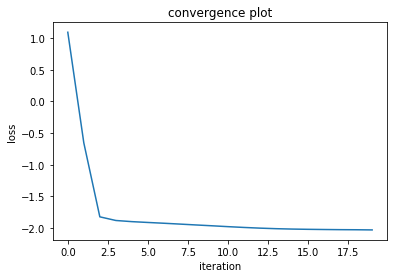

In [37]:
plt.plot(range(len(lossvec)),lossvec)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('convergence plot')

#### C3

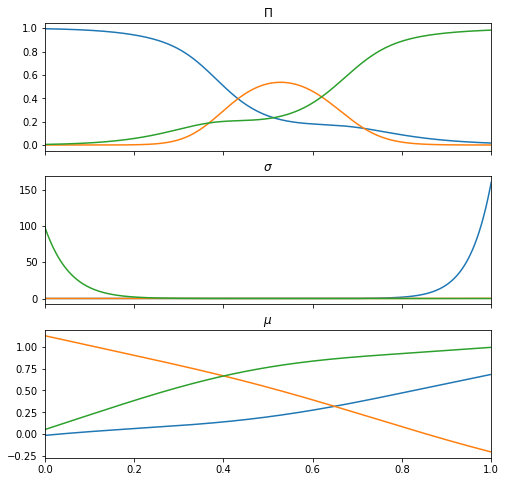

In [42]:
# evenly spaced samples from -10 to 10
x_test_data = np.linspace(0, 1, n_samples)

# change data shape, move from numpy to torch
x_test_tensor = torch.from_numpy(np.float32(x_test_data).reshape(n_samples, n_input))
x_test_variable = Variable(x_test_tensor)
y_test_variable = network(x_test_variable)

pi_variable, sigma_variable, mu_variable = network(x_test_variable)

pi_data = pi_variable.data.numpy()
sigma_data = sigma_variable.data.numpy()
mu_data = mu_variable.data.numpy()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,8))
ax1.plot(x_test_data, pi_data)
ax1.set_title('$\Pi$')
ax2.plot(x_test_data, sigma_data)
ax2.set_title('$\sigma$')
ax3.plot(x_test_data, mu_data)
ax3.set_title('$\mu$')
plt.xlim([0,1])
plt.show()

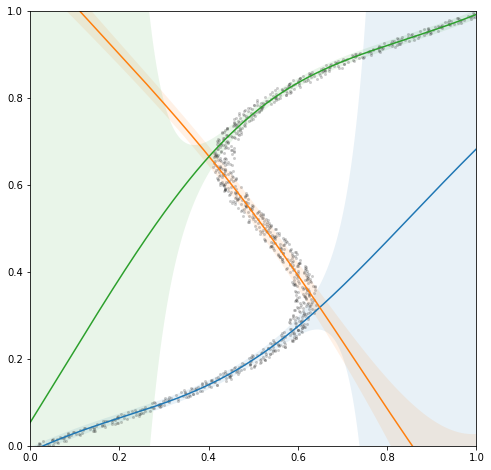

In [41]:
plt.figure(figsize=(8, 8), facecolor='white')
for mu_k, sigma_k in zip(mu_data.T, sigma_data.T):
    plt.plot(x_test_data, mu_k)
    plt.fill_between(x_test_data, mu_k-sigma_k, mu_k+sigma_k, alpha=0.1)
plt.scatter(mdn_x_data, mdn_y_data, marker='.', lw=0, alpha=0.2, c='black')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

#### C4

(0, 1)

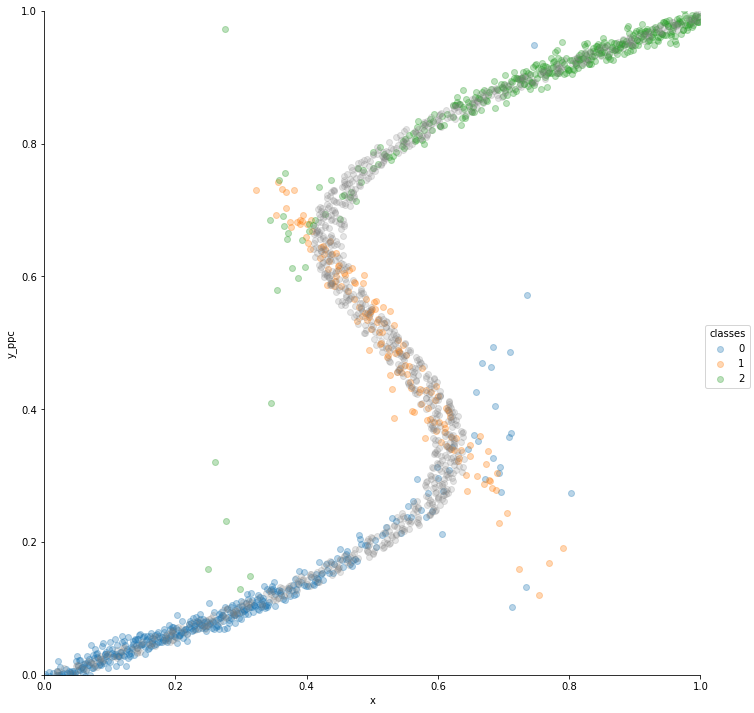

In [54]:
def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=axis)

k = gumbel_sample(pi_data)
indices = (np.arange(n_samples), k)
rn = np.random.randn(n_samples)
sampled = rn * sigma_data[indices] + mu_data[indices]

dflplot = pd.DataFrame()
dflplot['x'] = x_test_data
dflplot['y_ppc'] = sampled
dflplot['classes'] = k

sns.lmplot(x='x',y='y_ppc',data=dflplot,fit_reg=False,hue='classes',size=10,scatter_kws={'alpha':0.311})
plt.scatter(mdn_x_data, mdn_y_data, alpha=0.2,c='gray')
plt.xlim([0,1])
plt.ylim([0,1])


## Part D Variational Mixture Density Network

We want to implement the Mixture Density Metwork model that we constructed in Part C in directly in pymc3 and use variational inference to sample from it. We  may need more iterations in order to get convergence as this model will likely not converge as fast as the pytorch equivalent.

**D1**: Write out the equivalent pymc3 version of the MDN and generate posterior samples with ADVI.

**D2**: Sample from the posterior predictive as you did in B4 and produce a diagram like C4 and B5 for this model.

**D3**: Plot the "mean" regression curves (similar to C3 and B3). Do the "mean" regression curves in this model look the same from those in Part C?  If they differ why so?

#### D1

In [38]:
floatX = thenr.config.floatX
X = df.x.values.astype(floatX)
Y = df.target.values.astype(floatX)

In [39]:
X = X.reshape(-1,1)
Y = Y.reshape(-1,1)

In [40]:
X.shape

(1000, 1)

In [41]:
def construct_nn(ann_input):
    n_hidden = 20
    n_gaussians = 3
    # Initialize random weights between each layer
#     init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)    
#     mu_w = np.random.randn(n_hidden,n_gaussians).astype(floatX)
#     sigma_w = np.random.randn(n_hidden,n_gaussians).astype(floatX)
#     pi_w = np.random.randn(n_hidden,n_gaussians).astype(floatX)
    
    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=5,shape=(X.shape[1], n_hidden))
        weights_mu = pm.Normal('w_mu',0.,sd=5,shape=(n_hidden,n_gaussians))
        weights_sigma = pm.Normal('w_sigma',0.,sd=5,shape=(n_hidden,n_gaussians))
        weights_pi = pm.Normal('w_pi',0.,sd=5,shape=(n_hidden,n_gaussians))
        
        bias_in_1 = pm.Normal('b_in_1', 0, sd=5,shape=n_hidden)
        bias_mu = pm.Normal('b_mu',0.,sd=5,shape=n_gaussians)
        bias_sigma = pm.Normal('b_sigma',0.,sd=5,shape=n_gaussians)
        bias_pi = pm.Normal('b_pi',0.,sd=5,shape=n_gaussians)
        
        
        
        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input,weights_in_1)+bias_in_1)
        act_pi = pm.Deterministic('act_pi',var=tt.nnet.softmax(pm.math.dot(act_1,weights_pi)+bias_pi))
        act_sigma = pm.Deterministic('act_sigma',var=pm.math.exp(pm.math.dot(act_1,weights_sigma)+bias_sigma)+0.01)
        act_mu = pm.Deterministic('act_mu',var=pm.math.dot(act_1,weights_mu)+bias_mu)
        
        #fs = pm.NormalMixture('fs', w=act_pi, mu=act_mu, sd=act_sigma, observed=Y,total_size = Y.shape[0])
        fs = pm.NormalMixture('fs', w=act_pi, mu=act_mu, sd=act_sigma, observed=Y,total_size = 1000)
            
    return neural_network

ann_input = thenr.shared(X)
neural_network = construct_nn(ann_input)

In [42]:
with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=70000, method=inference,obj_optimizer=pm.adam())

Average Loss = -1,259: 100%|████████████████████████████████████████████████████| 70000/70000 [03:53<00:00, 299.94it/s]
Finished [100%]: Average Loss = -1,259.1


Text(0,0.5,'ELBO')

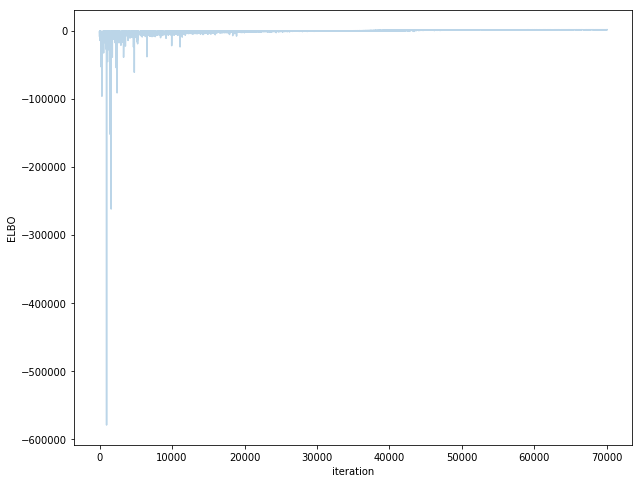

In [43]:
plt.figure(figsize=(10,8))
plt.plot(-inference.hist, label='new ADVI', alpha=.3)
plt.xlabel('iteration')
plt.ylabel('ELBO')

#### D2

In [44]:
trace = approx.sample(draws=10000)

(0, 1)

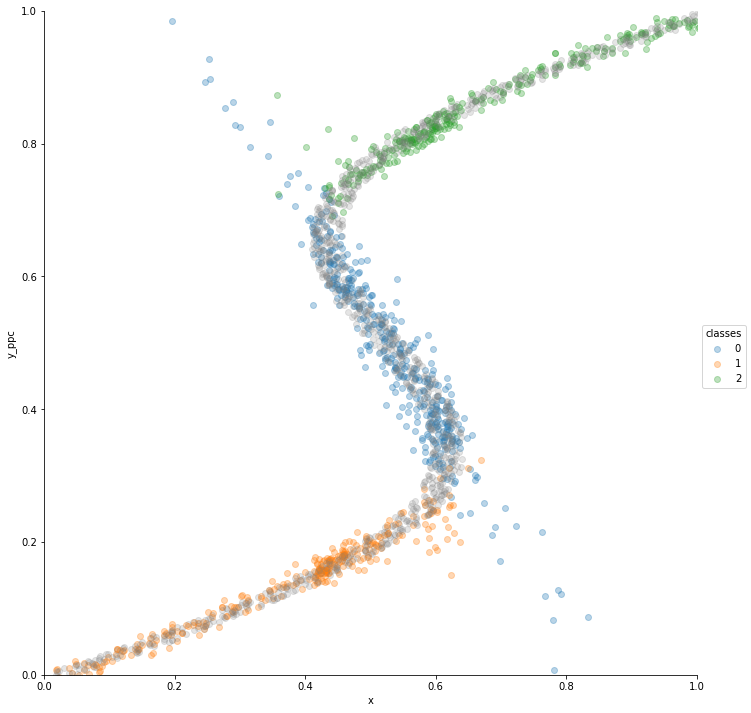

In [45]:
mus = trace['act_mu'].mean(axis=0)
stds = trace['act_sigma'].mean(axis=0)

def gumbel_max_sample(x):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=1)

classes = gumbel_max_sample(trace['act_pi'].mean(axis=0))

#compute yhat with the classes 
newvals = []
for i in range(len(classes)):
    newvals.append(np.random.normal(loc=mus[i,classes[i]],scale=stds[i,classes[i]])) 
    
dflplot = pd.DataFrame()
dflplot['x'] = df.x.values
dflplot['y_ppc'] = newvals
dflplot['classes'] = classes

sns.lmplot(x='x',y='y_ppc',data=dflplot,fit_reg=False,hue='classes',size=10,scatter_kws={'alpha':0.311})
plt.scatter(df.x.values, df.target.values, alpha=0.2,c='gray')
plt.xlim([0,1])
plt.ylim([0,1])


In [46]:
mus.shape

(1000, 3)

#### D3

Text(0,0.5,'mean of posterior mu')

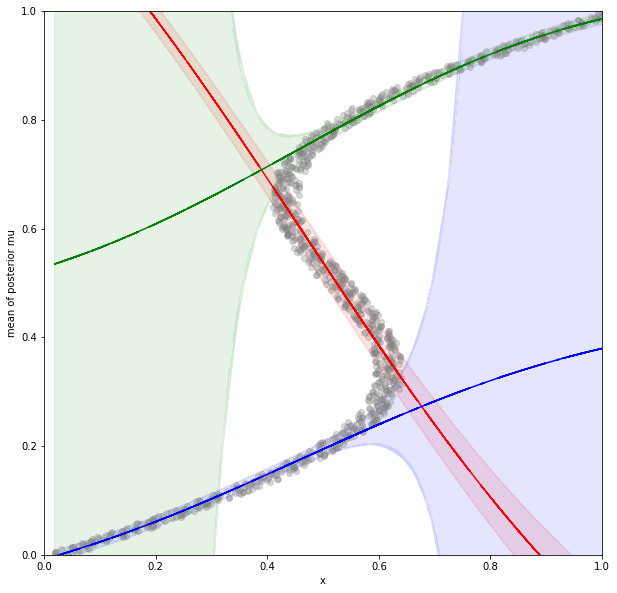

In [48]:
plt.figure(figsize=(10,10))
plt.plot(df.x.values,mus[:,0],c='r')
plt.plot(df.x.values,mus[:,1],c='b')
plt.plot(df.x.values,mus[:,2],c='g')
plt.fill_between(df.x.values,mus[:,0] -stds[:,0],mus[:,0]+stds[:,0], color='red', alpha=0.1)
plt.fill_between(df.x.values,mus[:,1] -stds[:,1],mus[:,1]+stds[:,1], color='blue', alpha=0.1)
plt.fill_between(df.x.values,mus[:,2] -stds[:,2],mus[:,2]+stds[:,2], color='g', alpha=0.1)
plt.scatter(df.x.values,df.target.values,c='grey',alpha=0.3)

plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('x')
plt.ylabel('mean of posterior mu')

The generated plot looks different to the one with torch. The reason for this is that we are using ADVI here which means we are not necessarily getting an accurate set of samples.

## Part E: Approximate EM for model in part B (EXTRA CREDIT)

Part B can be implemented using Expectation Maximization using iteratively-reweighted least squares. Our method in A was merely an approximation to this process. You can find update equations [here](https://people.eecs.berkeley.edu/~jordan/papers/jordan-xu.ps)